# **Task 3: Post-Training Quantization with SmoothQuant**

## **Overview**
Implements and evaluates **SmoothQuant**, an advanced **post-training quantization (PTQ)** method for large language models.  
The notebook diagnoses why naive quantization struggles, applies activation/weight smoothing, and measures the impact using **Perplexity (PPL)** on the **Wikitext** dataset.

---

## **Step 1: Environment and Data Preparation**

- **Baseline model:**  
  Load a full-precision **BF16** model as the gold-standard reference.

- **Dataset split:**  
  Load **Wikitext** and create two subsets:
  - **Calibration:** A small portion of the training set used to analyze activations and compute SmoothQuant scaling factors.  
  - **Evaluation:** The test set held out for fair PPL evaluation.

---

## **Step 2: Diagnosing the Quantization Challenge**

- **Activation capture:**  
  Use **forward hooks** to record input activations of selected linear layers on calibration batches.

- **Distribution plots:**  
  For each target layer, show side-by-side histograms of  
  (a) **weights** and  
  (b) **input activations**  
  to illustrate why standard quantization is difficult.

---

## **Step 3: Implementing the SmoothQuant Toolkit**

- **Basic quantizers:**  
  Implement **per-channel weight quantization (int8)** and **per-token activation quantization (int8)**.

- **Quantized layer:**  
  Define **`WnAnLinear`**, a drop-in `nn.Linear` replacement that stores quantized weights and dynamically quantizes activations in its forward pass.

- **Smoothing core:**  
  Implement **`smooth_ln_fcs`**, which scales activations down and weights up using factors derived from their distributions—shifting quantization difficulty from activations to weights.

- **Model wrappers:**  
  - **`smooth_model`** applies smoothing across the model.  
  - **`quantize_model`** replaces eligible linear layers with the quantized variant.

---

## **Step 4: Calibration and Evaluation Workflow**

- **Activation scaling:**  
  **`get_act_scales`** runs the calibration set with hooks to compute per-channel activation maxima for smoothing.

- **Perplexity evaluator:**  
  **`Evaluator`** tokenizes data, computes loss, and reports **PPL** (lower is better) on the **Wikitext** test set.

---

## **Step 5: Main Experiments**

- **Configurations:**  
  For example define runs for:
  - **BF16 baseline**
  - **Naive W8A8**
  - **W8A8 + SmoothQuant**

- **Orchestration:**  
  **`run_experiment`** loads the model, optionally smooths, quantizes, and evaluates PPL.

- **Models:**  
  Execute across multiple LLMs (e.g., **Llama-3-8B** and **Llama-2-7B**) and record results.

---

## **Step 6: Results and Conclusions**

- **Aggregation:**  
  Collect PPLs into a **pandas DataFrame** and print a concise summary table to compare **SmoothQuant**, **naive W8A8**, and the **BF16 baseline**.


In [1]:
### Cell 2: Environment Setup and Dependency Installation
import os
import random
import time
from functools import partial
from typing import Optional, Tuple, Callable
import types

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from scipy.stats import linregress
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.generation.stopping_criteria import (
    StoppingCriteria,
    StoppingCriteriaList,
)
from transformers.modeling_utils import ALL_ATTENTION_FUNCTIONS
from transformers.models.llama.modeling_llama import (
    LlamaAttention,
    rotate_half,
    repeat_kv,
)
from transformers.utils import logging

RESULTS_DIR = "./results"
FIGURES_DIR = "./figures"
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    # TODO: Optionally log GPU diagnostics here.
else:
    DEVICE = torch.device("cpu")
    # TODO: Optionally log CPU fallback diagnostics here.
    raise RuntimeError("Come on bro, you need a GPU")

def set_seed(seed=42):
    """Set random seeds for reproducibility across Python, NumPy, and PyTorch."""
    # TODO: Implement reproducibility setup.
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("\n   Environment setup and dependency installation complete.")


/home/hice1/samin68/scratch/miniconda3/envs/cs4650/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



   Environment setup and dependency installation complete.


In [ ]:
# ### Cell 3: Hugging Face Login
from huggingface_hub import login, HfFolder
from getpass import getpass

# Check if a Hugging Face token is already set in the environment.
if not os.getenv("HUGGING_FACE_HUB_TOKEN"):
    try:
        # Prompt user for Hugging Face access token if not found.
        hf_token = "ojskdng;JGoshgjkshgilkjeasdghjsl;dkagjnlk;asdgjl;sdgjasdlk;gjkl;sadlkjgsaKDLJ;GJLK;DSLJKWD/lkj/gkljsdfgkljfdskljgkljdsflkjhfdkl;j"
        login(token=hf_token, add_to_git_credential=True)
        print("   Hugging Face login successful!")
    except Exception as e:
        print(f"Login failed: {e}. Model loading may fail later.")
else:
    print("   Hugging Face token detected.")

Token has not been saved to git credential helper.


Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.
   Hugging Face login successful!


In [3]:
### Cell 4: Model, Tokenizer, and Dataset Loading
MODEL_ID = "meta-llama/Llama-3.1-8B-Instruct"

def load_model_and_tokenizer(model_id):
    """
    Loads a specified Hugging Face model and its tokenizer in bfloat16 precision.
    """
    # TODO: Load model and tokenizer for the provided identifier.
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        device_map=DEVICE, 
        dtype="auto"        
    )
    tokenizer = AutoTokenizer.from_pretrained(model_id)

    print(f"Successfully loaded model: {model_id}")

    return model, tokenizer

# Task 3, Step 1: Load the baseline BF16 model for quantization experiments
print("\nLoading bf16 model...")
model_fp16, tokenizer = load_model_and_tokenizer(MODEL_ID)

# Task 3, Step 1: Load the Wikitext dataset for calibration and evaluation
print("\nLoading Wikitext dataset...")
calibration_dataset = load_dataset("Salesforce/wikitext", "wikitext-103-v1", split="test")  # TODO: Prepare calibration dataset
eval_dataset = load_dataset("Salesforce/wikitext", "wikitext-103-v1", split="validation")  # TODO: Prepare evaluation dataset
print("   Dataset loaded successfully.")



Loading bf16 model...


Loading checkpoint shards: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]


Successfully loaded model: meta-llama/Llama-3.1-8B-Instruct

Loading Wikitext dataset...
   Dataset loaded successfully.


Saved weight and activation distributions to ./figures/task_3_weight_activation_distributions.png


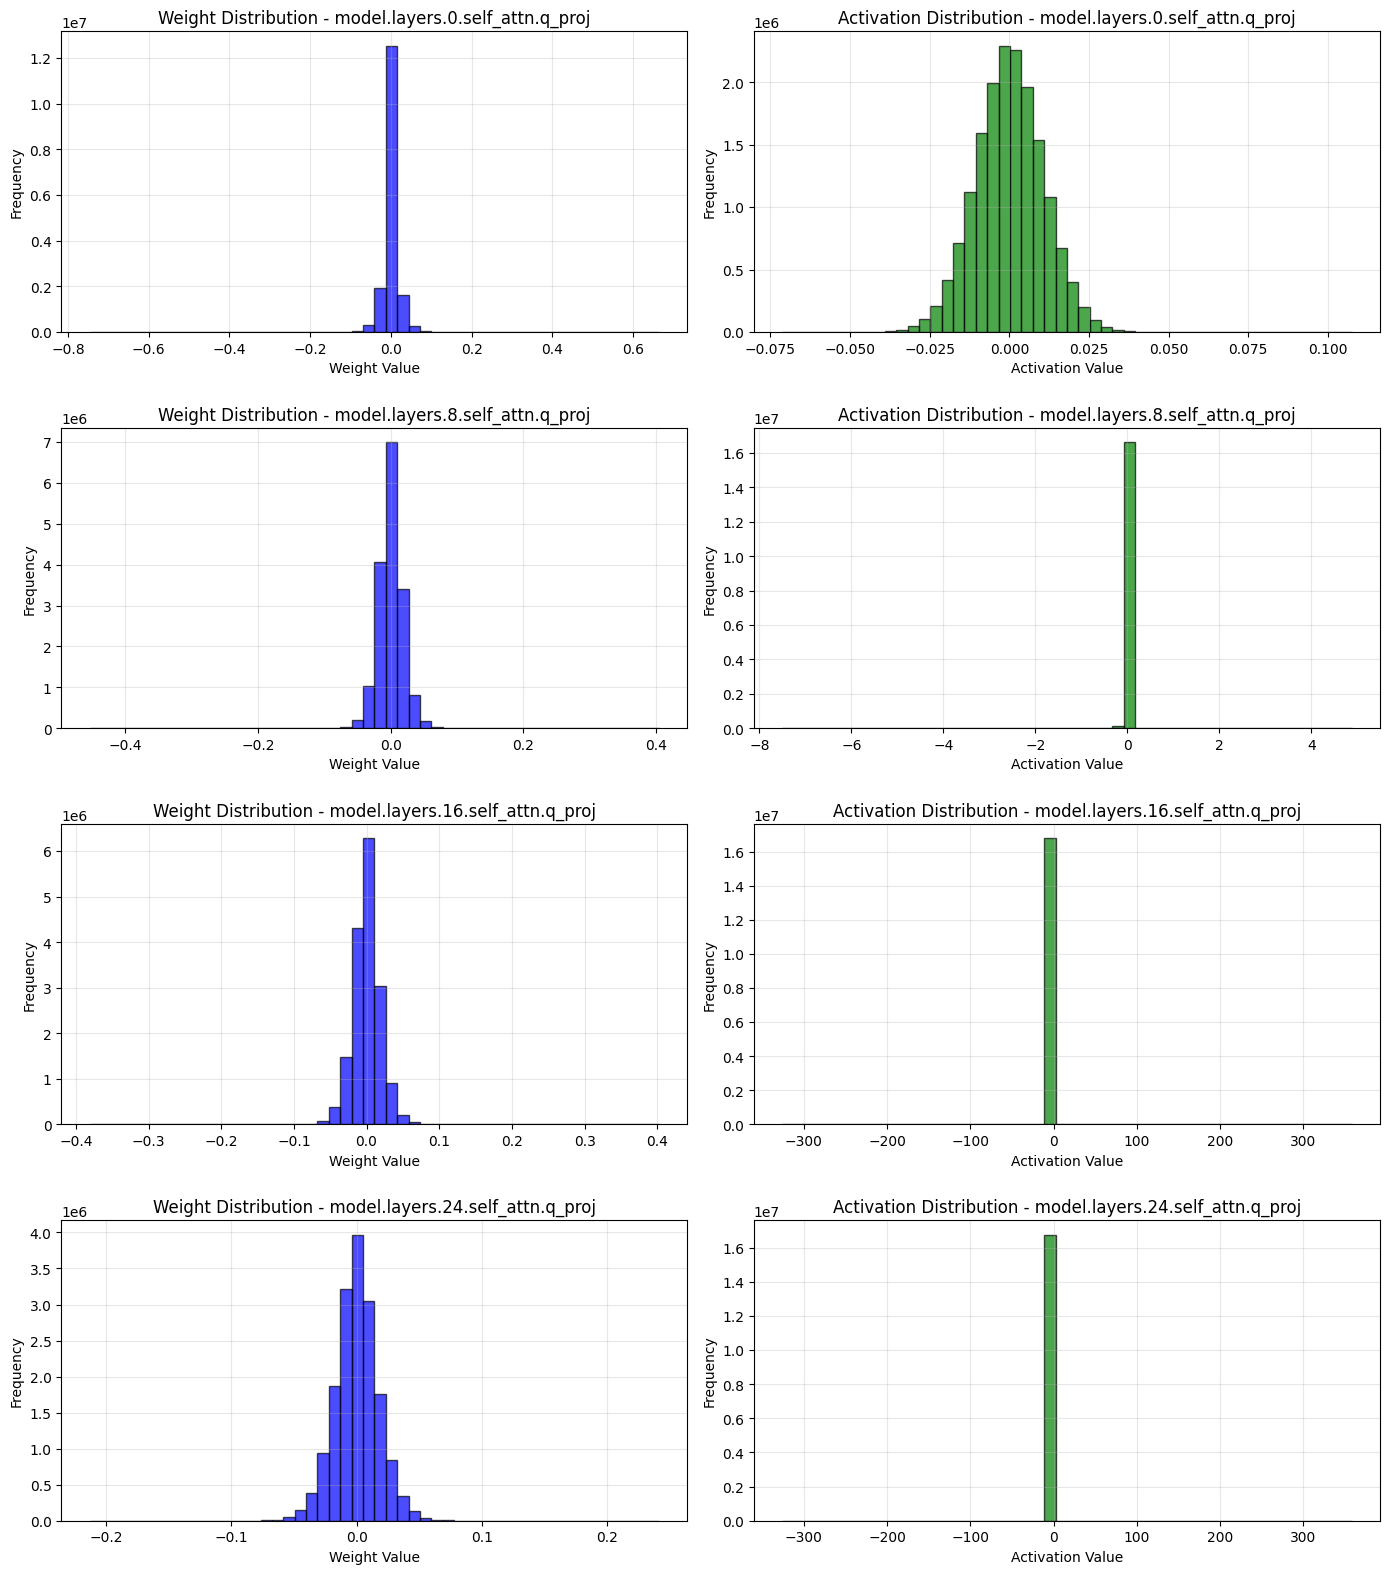

Saved 3D activation surfaces to ./figures/task_3_activation_surfaces_3d.png


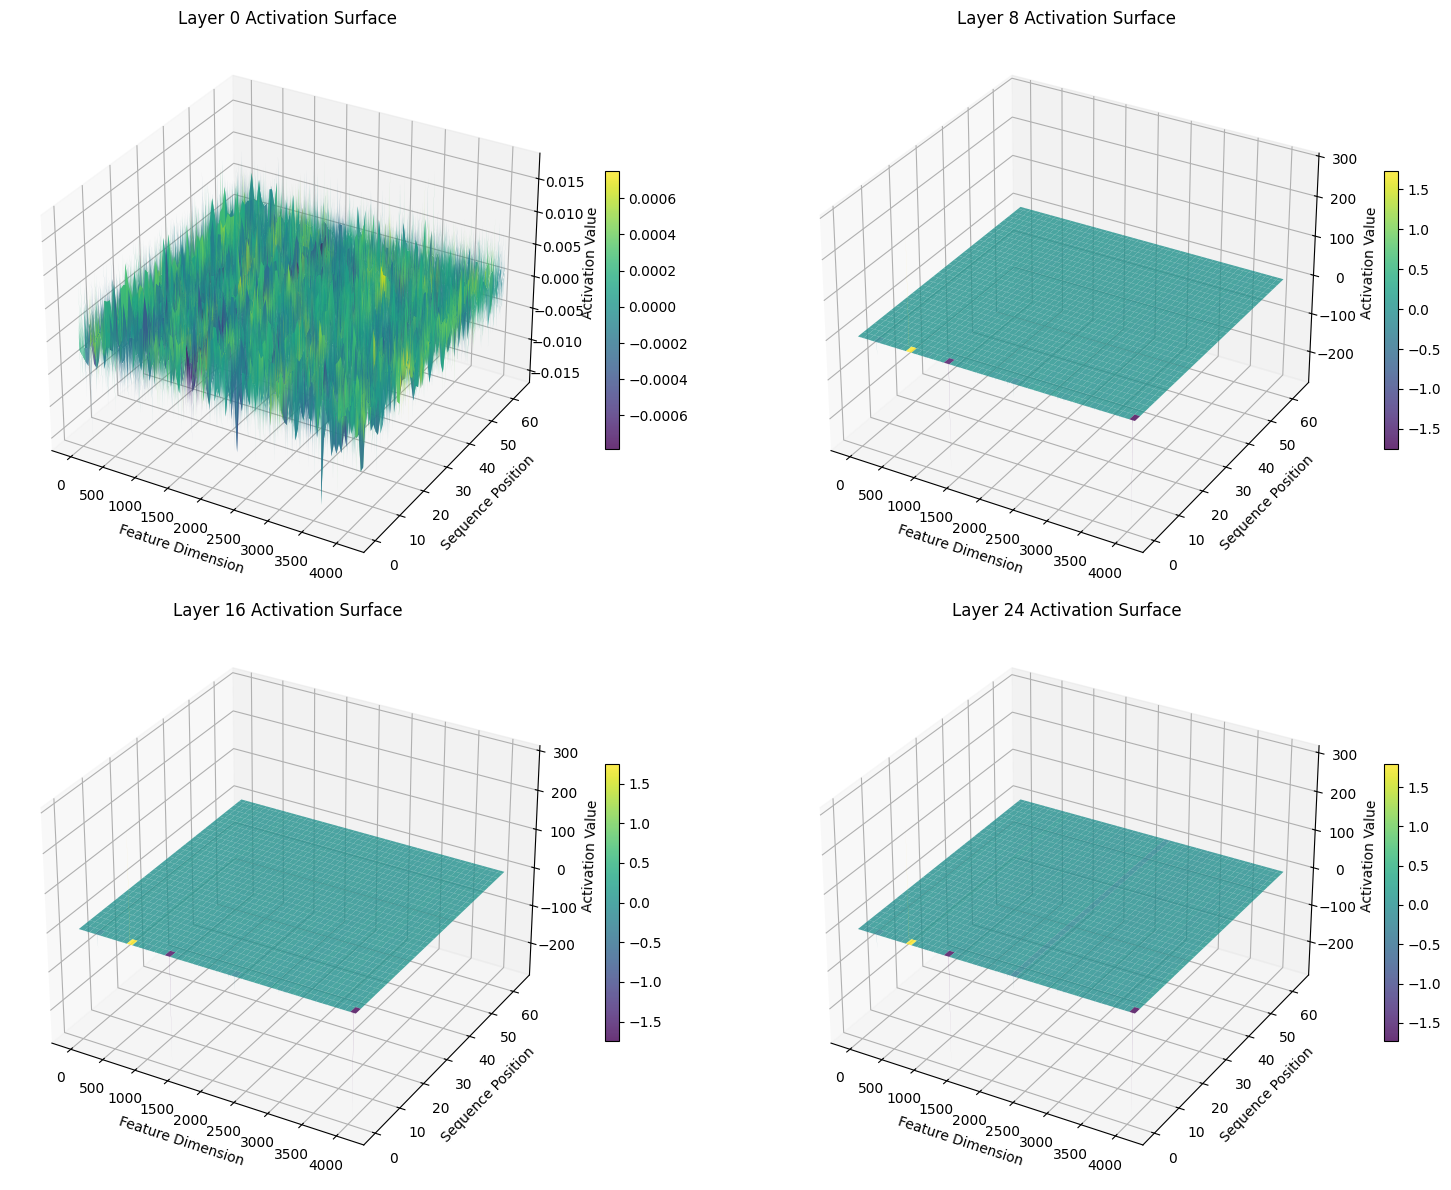

'\nWeight and Activation Distribution Analysis\n\nTODO: Summarize observed phenomena and conclusions after completing the visualizations.\n'

In [4]:
### Cell 5: Visualization of Weight and Activation Distributions

from collections import defaultdict

def visualize_distributions(model, tokenizer):
    """
    Visualizes the distribution of weights and input activations for selected layers.
    """
    CALIBRATION_SAMPLES = 32  # TODO: Choose number of calibration samples
    SEQ_LEN = 128  # TODO: Choose calibration sequence length
    NUM_BINS = 50  # TODO: Choose number of histogram bins
    LAYERS_TO_VISUALIZE = [
        # TODO: Specify representative layer names
        "model.layers.0.self_attn.q_proj",
        "model.layers.8.self_attn.q_proj",
        "model.layers.16.self_attn.q_proj",
        "model.layers.24.self_attn.q_proj",
    ]
    # TODO: Collect activations and plot distributions.
    
    activation_stats = defaultdict(list)
    weight_stats = {}
    
    for layer_name in LAYERS_TO_VISUALIZE:
        layer = model.get_submodule(layer_name)
        if hasattr(layer, "weight"):
            weight_stats[layer_name] = layer.weight.detach().cpu().float().numpy().flatten()
    
    for sample_idx in range(CALIBRATION_SAMPLES):
        dummy_input_ids = torch.randint(0, len(tokenizer), (1, SEQ_LEN), device=DEVICE)
        
        with torch.no_grad():
            outputs = model(dummy_input_ids, output_hidden_states=True)
        
        hidden_states = outputs.hidden_states
        
        for layer_idx, layer_name in enumerate(LAYERS_TO_VISUALIZE):
            if layer_idx < len(hidden_states):
                activation = hidden_states[layer_idx].detach().cpu().float().numpy().flatten()
                activation_stats[layer_name].append(activation)
    
    fig, axes = plt.subplots(len(LAYERS_TO_VISUALIZE), 2, figsize=(14, 4 * len(LAYERS_TO_VISUALIZE)))
    
    for idx, layer_name in enumerate(LAYERS_TO_VISUALIZE):
        if layer_name in weight_stats:
            axes[idx, 0].hist(weight_stats[layer_name], bins=NUM_BINS, alpha=0.7, color="blue", edgecolor="black")
            axes[idx, 0].set_title(f"Weight Distribution - {layer_name}")
            axes[idx, 0].set_xlabel("Weight Value")
            axes[idx, 0].set_ylabel("Frequency")
            axes[idx, 0].grid(True, alpha=0.3)
        
        if layer_name in activation_stats:
            all_activations = np.concatenate(activation_stats[layer_name])
            axes[idx, 1].hist(all_activations, bins=NUM_BINS, alpha=0.7, color="green", edgecolor="black")
            axes[idx, 1].set_title(f"Activation Distribution - {layer_name}")
            axes[idx, 1].set_xlabel("Activation Value")
            axes[idx, 1].set_ylabel("Frequency")
            axes[idx, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("./figures/task_3_weight_activation_distributions.png", dpi=300, bbox_inches="tight")
    print("Saved weight and activation distributions to ./figures/task_3_weight_activation_distributions.png")
    plt.show()

def visualize_distributions_3d(model, tokenizer):
    """
    Generates 3D activation surface plots for representative layers.
    """
    CALIBRATION_SAMPLES = 16  # TODO: Choose number of calibration samples
    SEQ_LEN = 64  # TODO: Choose calibration sequence length
    LAYERS_TO_VISUALIZE = [
        # TODO: Specify representative layer names
        0, 8, 16, 24
    ]
    # TODO: Collect activations and render 3D plots.
    
    fig = plt.figure(figsize=(16, 12))
    
    for plot_idx, layer_idx in enumerate(LAYERS_TO_VISUALIZE):
        activation_maps = []
        
        for sample_idx in range(CALIBRATION_SAMPLES):
            dummy_input_ids = torch.randint(0, len(tokenizer), (1, SEQ_LEN), device=DEVICE)
            
            with torch.no_grad():
                outputs = model(dummy_input_ids, output_hidden_states=True)
            
            hidden_states = outputs.hidden_states
            
            if layer_idx < len(hidden_states):
                activation = hidden_states[layer_idx][0].detach().cpu().float().numpy()
                activation_maps.append(activation)
        
        if activation_maps:
            activation_array = np.stack(activation_maps)
            mean_activation = activation_array.mean(axis=0)
            
            ax = fig.add_subplot(2, 2, plot_idx + 1, projection="3d")
            
            x = np.arange(mean_activation.shape[0])
            y = np.arange(mean_activation.shape[1])
            X, Y = np.meshgrid(y, x)
            
            surf = ax.plot_surface(X, Y, mean_activation, cmap="viridis", alpha=0.8)
            ax.set_title(f"Layer {layer_idx} Activation Surface")
            ax.set_xlabel("Feature Dimension")
            ax.set_ylabel("Sequence Position")
            ax.set_zlabel("Activation Value")
            fig.colorbar(surf, ax=ax, shrink=0.5)
    
    plt.tight_layout()
    plt.savefig("./figures/task_3_activation_surfaces_3d.png", dpi=300, bbox_inches="tight")
    print("Saved 3D activation surfaces to ./figures/task_3_activation_surfaces_3d.png")
    plt.show()

# Task 3, Step 2: Visualize weight and activation distributions to motivate SmoothQuant
visualize_distributions(model_fp16, tokenizer)
visualize_distributions_3d(model_fp16, tokenizer)

"""
Weight and Activation Distribution Analysis

TODO: Summarize observed phenomena and conclusions after completing the visualizations.
"""

In [5]:
print(model_fp16)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_

In [6]:
print(model_fp16.model.layers[0].mlp.gate_proj)
print(model_fp16.model.layers[0].mlp.gate_proj.weight.shape)

Linear(in_features=4096, out_features=14336, bias=False)
torch.Size([14336, 4096])


In [7]:
### Cell 6: Core Implementation of SmoothQuant

# --------------------------------------------------------------------------------
# Part 1: Quantizers
# --------------------------------------------------------------------------------

@torch.no_grad()
def quantize_weight_per_channel_absmax(w, n_bits=8):
    # w: (out_features, in_features)
    scales = w.abs().max(dim=-1, keepdim=True)[0]
    q_max = 2 ** (n_bits - 1) - 1
    scales.clamp_(min=1e-5).div_(q_max)
    w.div_(scales).round_().mul_(scales)
    return w

@torch.no_grad()
def quantize_activation_per_token_absmax(t, n_bits=8):
    t_shape = t.shape
    t.view(-1, t_shape[-1])
    scales = t.abs().max(dim=-1, keepdim=True)[0]
    q_max = 2 ** (n_bits - 1) - 1
    scales.clamp_(min=1e-5).div_(q_max)
    t.div_(scales).round_().mul_(scales)
    return t


# check quantization
dummy_input_ids = torch.randint(0, len(tokenizer), (1, 128), device=DEVICE)

with torch.no_grad():
    outputs = model_fp16(dummy_input_ids, output_hidden_states=True)

for layer in [0, 8, 16, 24]:
    hidden_states = outputs.hidden_states[layer][0]

    q_hidden_states = quantize_activation_per_token_absmax(hidden_states.clone())

    print(f"Error for layer {layer} is {F.l1_loss(q_hidden_states, hidden_states).item():.6f}")


# --------------------------------------------------------------------------------
# Part 2: Quantized Linear Layer
# --------------------------------------------------------------------------------

class WnAnLinear(nn.Module):
    """
    Quantized Linear Layer with per-channel weight and per-token activation quantization.
    """
    def __init__(
        self,
        in_features,
        out_features,
        bias=True,
        act_quant="per_token",
        quantize_output=False,
    ):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.register_buffer(
            "weight",
            torch.randn(
                self.out_features,
                self.in_features,
                dtype=torch.float16,
                requires_grad=False,
            ),
        )
        if bias:
            self.register_buffer(
                "bias",
                torch.zeros(
                    (1, self.out_features), dtype=torch.float16, requires_grad=False
                ),
            )
        else:
            self.register_buffer("bias", None)

        if act_quant == "per_token":
            self.act_quant_name = "per_token"
            self.act_quant = partial(quantize_activation_per_token_absmax, n_bits=8)
        elif act_quant == "per_tensor":
            raise RuntimeError("Unsupported!")
        else:
            raise ValueError(f"Invalid act_quant: {act_quant}")

        if quantize_output:
            self.output_quant_name = self.act_quant_name
            self.output_quant = self.act_quant
        else:
            self.output_quant_name = "None"
            self.output_quant = lambda x: x

    def to(self, *args, **kwargs):
        super(WnAnLinear, self).to(*args, **kwargs)
        self.weight = self.weight.to(*args, **kwargs)
        if self.bias is not None:
            self.bias = self.bias.to(*args, **kwargs)
        return self

    @torch.no_grad()
    def forward(self, x):
        q_x = self.act_quant(x)
        y = torch.functional.F.linear(q_x, self.weight, self.bias)
        q_y = self.output_quant(y)
        return q_y

    @staticmethod
    def from_float(
        module, weight_quant="per_channel", act_quant="per_token", quantize_output=False
    ):
        assert isinstance(module, torch.nn.Linear)
        new_module = WnAnLinear(
            module.in_features,
            module.out_features,
            module.bias is not None,
            act_quant=act_quant,
            quantize_output=quantize_output,
        )
        if weight_quant == "per_channel":
            new_module.weight = quantize_weight_per_channel_absmax(
                module.weight, n_bits=8
            )  # use 8-bit integer for weight
        elif weight_quant == "per_tensor":
            raise RuntimeError("Unsupported!")
        else:
            raise ValueError(f"Invalid weight_quant: {weight_quant}")
        new_module.weight_quant_name = weight_quant
        if module.bias is not None:
            new_module.bias = module.bias
        return new_module

    def __repr__(self):
        return f"WnAnLinear({self.in_features}, {self.out_features}, bias={self.bias is not None}, weight_quant={self.weight_quant_name}, act_quant={self.act_quant_name}, output_quant={self.output_quant_name})"


# --------------------------------------------------------------------------------
# Part 3: Smoothing Function (SmoothQuant)
# --------------------------------------------------------------------------------

@torch.no_grad()
def smooth_ln_fcs(ln, fcs, act_scales, alpha=0.5):
    if not isinstance(fcs, list):
        fcs = [fcs]
    for fc in fcs:
        assert isinstance(fc, nn.Linear)
        assert ln.weight.numel() == fc.in_features == act_scales.numel()
    device, dtype = fcs[0].weight.device, fcs[0].weight.dtype
    act_scales = act_scales.to(device=device, dtype=dtype)
    weight_scales = torch.cat(
        [fc.weight.abs().max(dim=0, keepdim=True)[0] for fc in fcs], dim=0
    )
    weight_scales = weight_scales.max(dim=0)[0].clamp(min=1e-5)
    scales = (
        (act_scales.pow(alpha) / weight_scales.pow(1 - alpha))
        .clamp(min=1e-5)
        .to(device)
        .to(dtype)
    )

    ln.weight.div_(scales)
    for fc in fcs:
        fc.weight.mul_(scales.view(1, -1))
        


def find_layers(module, layers=(nn.Linear,), name=""):
    """
    Recursively finds layers of specified types within a module.
    """
    # TODO: Return mapping from qualified layer names to layer modules.
    if isinstance(module, layers):
        return {name: module}
    
    res = {}
    for child_name, child_module in module.named_children():
        full_name = f"{name}.{child_name}" if name else child_name
        res.update(find_layers(child_module, layers, full_name))
    
    return res

@torch.no_grad()
def smooth_model(model, act_scales, alpha=0.5):
    """
    Applies SmoothQuant smoothing across the entire model.
    """
    # TODO: Iterate over model layers and apply smoothing with the provided activation scales.
    print(f"Saved keys {act_scales.keys()}")
    for layer_idx in range(len(model.model.layers)):
        layer = model.model.layers[layer_idx]
        
        if f"model.layers.{layer_idx}.input_layernorm" in act_scales:
            ln = layer.input_layernorm
            fcs = [layer.self_attn.q_proj, layer.self_attn.k_proj, layer.self_attn.v_proj]
            scales = act_scales[f"model.layers.{layer_idx}.input_layernorm"]
            smooth_ln_fcs(ln, fcs, scales, alpha)
        
        if f"model.layers.{layer_idx}.post_attention_layernorm" in act_scales:
            ln = layer.post_attention_layernorm
            fcs = [layer.mlp.gate_proj, layer.mlp.up_proj]
            scales = act_scales[f"model.layers.{layer_idx}.post_attention_layernorm"]
            smooth_ln_fcs(ln, fcs, scales, alpha)

def quantize_model(model, w_bits=8, a_bits=8, weight_quant="per_channel", act_quant="per_token", quantize_bmm_input=False):
    """
    Replaces target linear layers with their quantized counterparts.
    """
    print(f"Warning: ignoring arguments w_bits={w_bits} and a_bits={a_bits}. Forcing 8-bit quantization for everything")

    # TODO: Convert and swap model linear layers with quantized versions.
    from transformers.models.llama.modeling_llama import (
        LlamaAttention,
        LlamaMLP,
    )

    from transformers.models.mistral.modeling_mistral import (
        MistralAttention,
        MistralMLP,
    )

    for name, m in model.model.named_modules():
        if isinstance(m, (LlamaMLP, MistralMLP)):
            m.gate_proj = WnAnLinear.from_float(
                m.gate_proj, weight_quant=weight_quant, act_quant=act_quant
            )
            m.up_proj = WnAnLinear.from_float(
                m.up_proj, weight_quant=weight_quant, act_quant=act_quant
            )
            m.down_proj = WnAnLinear.from_float(
                m.down_proj, weight_quant=weight_quant, act_quant=act_quant
            )
        elif isinstance(m, (LlamaAttention, MistralAttention)):
            # Her we simulate quantizing BMM inputs by quantizing the output of q_proj, k_proj, v_proj
            m.q_proj = WnAnLinear.from_float(
                m.q_proj,
                weight_quant=weight_quant,
                act_quant=act_quant,
                quantize_output=quantize_bmm_input,
            )
            m.k_proj = WnAnLinear.from_float(
                m.k_proj,
                weight_quant=weight_quant,
                act_quant=act_quant,
                quantize_output=quantize_bmm_input,
            )
            m.v_proj = WnAnLinear.from_float(
                m.v_proj,
                weight_quant=weight_quant,
                act_quant=act_quant,
                quantize_output=quantize_bmm_input,
            )
            m.o_proj = WnAnLinear.from_float(
                m.o_proj, weight_quant=weight_quant, act_quant=act_quant
            )
    return model



Error for layer 0 is 0.000081
Error for layer 8 is 0.004059
Error for layer 16 is 0.007721
Error for layer 24 is 0.026733


In [8]:
### Cell 7: Activation Scale Calibration & Perplexity Evaluation

# --------------------------------------------------------------------------------
# Part 1: Activation Scale Calibration
# --------------------------------------------------------------------------------

import tqdm
import functools

@torch.no_grad()
def get_act_scales(model, tokenizer, dataset, num_samples=512, seq_len=512):
    model.eval()
    device = next(model.parameters()).device
    act_scales = {}

    def stat_tensor(name, tensor):
        hidden_dim = tensor.shape[-1]
        tensor = tensor.view(-1, hidden_dim).abs().detach()
        comming_max = torch.max(tensor, dim=0)[0].float().cpu()
        if name in act_scales:
            act_scales[name] = torch.max(act_scales[name], comming_max)
        else:
            act_scales[name] = comming_max

    def stat_input_hook(m, x, y, name):
        if isinstance(x, tuple):
            x = x[0]
        stat_tensor(name, x)

    hooks = []
    for name, m in model.named_modules():
        if "layernorm" in name:
            hooks.append(
                m.register_forward_hook(functools.partial(stat_input_hook, name=name))
            )

    for i in tqdm.tqdm(range(num_samples)):
        input_ids = tokenizer(
            dataset[i]["text"], return_tensors="pt", max_length=seq_len, truncation=True
        ).input_ids.to(device)
        model(input_ids)

    for h in hooks:
        h.remove()

    return act_scales


# --------------------------------------------------------------------------------
# Part 2: Perplexity Evaluator
# --------------------------------------------------------------------------------

class Evaluator:
    """
    Evaluates the perplexity of a language model on a given dataset.
    """
    def __init__(self, dataset, tokenizer, device, n_samples=128):
        # TODO: Store references and pre-tokenize evaluation corpus.
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.device = device
        self.n_samples = n_samples
        
        print(f"Disregarding n_samples. Was given {n_samples}, but actually using entire dataset {len(dataset)}")

        self.tokenized_data = []
        for i in range(len(dataset)):
            text = dataset[i]["text"]
            tokens = tokenizer(text, return_tensors="pt", truncation=False)
            self.tokenized_data.append(tokens.input_ids[0])

    @torch.no_grad()
    def evaluate(self, model, seq_len=2048):
        """
        Computes the perplexity of the model on the evaluation dataset.
        """
        # TODO: Implement perplexity evaluation loop.
        model.eval()
        total_loss = 0.0
        total_tokens = 0
        
        for input_ids in tqdm.tqdm(self.tokenized_data):
            if len(input_ids) <= 1:
                continue
            
            num_chunks = (len(input_ids) - 1) // seq_len + 1
            
            for chunk_idx in range(num_chunks):
                start_idx = chunk_idx * seq_len
                end_idx = min(start_idx + seq_len + 1, len(input_ids))
                
                if end_idx - start_idx <= 1:
                    continue
                
                chunk_ids = input_ids[start_idx:end_idx].unsqueeze(0).to(self.device)
                
                outputs = model(chunk_ids, labels=chunk_ids)
                loss = outputs.loss
                
                num_tokens = chunk_ids.shape[1] - 1
                total_loss += loss.item() * num_tokens
                total_tokens += num_tokens
        
        if total_tokens == 0:
            return float("inf")
        
        avg_loss = total_loss / total_tokens
        perplexity = torch.exp(torch.tensor(avg_loss)).item()
        
        return perplexity

In [9]:
### Cell 8: Main Experiment - Apply SmoothQuant and Evaluate

def run_experiment(model_id, quant_config, calibration_ds, evaluation_ds):
    """
    Runs a complete quantization experiment: load, (optionally) smooth, quantize, and evaluate.
    """
    # TODO: Implement experiment pipeline (load baseline, optional smoothing/quantization, evaluation).
    print(f"\n{'='*80}")
    print(f"Running experiment: {quant_config['name']}")
    print(f"Model: {model_id}")
    print(f"{'='*80}")
    
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        device_map=DEVICE
    )
    
    if quant_config["smooth"]:
        print("Collecting activation scales...")
        act_scales = get_act_scales(
            model, 
            tokenizer, 
            calibration_ds, 
            num_samples=quant_config.get("calib_samples", 256),
            seq_len=quant_config.get("calib_seq_len", 512)
        )
        
        print(f"Applying SmoothQuant with alpha={quant_config['alpha']}...")
        smooth_model(model, act_scales, alpha=quant_config["alpha"])
    
    if quant_config["quantize"]:
        print(f"Quantizing model (W{quant_config['w_bits']}A{quant_config['a_bits']})...")
        quantize_model(model, w_bits=quant_config["w_bits"], a_bits=quant_config["a_bits"])
    
    print("Evaluating perplexity...")
    evaluator = Evaluator(
        evaluation_ds, 
        tokenizer, 
        device=DEVICE,
        n_samples=quant_config.get("eval_samples", 128)
    )
    perplexity = evaluator.evaluate(model, seq_len=quant_config.get("eval_seq_len", 2048))
    
    print(f"Perplexity: {perplexity:.8f}")
    
    del model
    torch.cuda.empty_cache()
    
    return perplexity

# --- Experiment Configurations ---
experiment_configs = {
    "Llama-3-8B": {
        # TODO: Define configuration name -> quantization settings.
        "FP16-Baseline": {
            "name": "FP16-Baseline",
            "smooth": False,
            "quantize": False,
            "w_bits": 16,
            "a_bits": 16,
            "alpha": 0.5,
            "calib_samples": 256,
            "calib_seq_len": 512,
            "eval_samples": 128,
            "eval_seq_len": 2048
        },
        "W8A8-NoSmooth": {
            "name": "W8A8-NoSmooth",
            "smooth": False,
            "quantize": True,
            "w_bits": 8,
            "a_bits": 8,
            "alpha": 0.5,
            "calib_samples": 256,
            "calib_seq_len": 512,
            "eval_samples": 128,
            "eval_seq_len": 2048
        },
        "W8A8-SmoothQuant-0.5": {
            "name": "W8A8-SmoothQuant-0.5",
            "smooth": True,
            "quantize": True,
            "w_bits": 8,
            "a_bits": 8,
            "alpha": 0.5,
            "calib_samples": 256,
            "calib_seq_len": 512,
            "eval_samples": 128,
            "eval_seq_len": 2048
        },
        "W8A8-SmoothQuant-0.75": {
            "name": "W8A8-SmoothQuant-0.75",
            "smooth": True,
            "quantize": True,
            "w_bits": 8,
            "a_bits": 8,
            "alpha": 0.75,
            "calib_samples": 256,
            "calib_seq_len": 512,
            "eval_samples": 128,
            "eval_seq_len": 2048
        }
    },
    "Llama-2-7B": {
        # TODO: Define configuration name -> quantization settings.
        "FP16-Baseline": {
            "name": "FP16-Baseline",
            "smooth": False,
            "quantize": False,
            "w_bits": 16,
            "a_bits": 16,
            "alpha": 0.5,
            "calib_samples": 256,
            "calib_seq_len": 512,
            "eval_samples": 128,
            "eval_seq_len": 2048
        },
        "W8A8-NoSmooth": {
            "name": "W8A8-NoSmooth",
            "smooth": False,
            "quantize": True,
            "w_bits": 8,
            "a_bits": 8,
            "alpha": 0.5,
            "calib_samples": 256,
            "calib_seq_len": 512,
            "eval_samples": 128,
            "eval_seq_len": 2048
        },
        "W8A8-SmoothQuant-0.5": {
            "name": "W8A8-SmoothQuant-0.5",
            "smooth": True,
            "quantize": True,
            "w_bits": 8,
            "a_bits": 8,
            "alpha": 0.5,
            "calib_samples": 256,
            "calib_seq_len": 512,
            "eval_samples": 128,
            "eval_seq_len": 2048
        }
    }
}

MODEL_MAPPING = {
    # TODO: Map display names to Hugging Face model identifiers.
    "Llama-3-8B": "meta-llama/Meta-Llama-3-8B", 
    "Llama-2-7B": "meta-llama/Llama-2-7b-hf"
}

# --- Run all experiments and collect results ---
results = {}
for model_name, configs in experiment_configs.items():
    results[model_name] = {}
    model_id = MODEL_MAPPING[model_name]
    
    for config_name, config in configs.items():
        # TODO: Execute experiment and record perplexity.
        perplexity = run_experiment(model_id, config, calibration_dataset, eval_dataset)
        results[model_name][config_name] = perplexity


Running experiment: FP16-Baseline
Model: meta-llama/Meta-Llama-3-8B


`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Evaluating perplexity...
Disregarding n_samples. Was given 128, but actually using entire dataset 3760


100%|██████████| 3760/3760 [00:40<00:00, 92.42it/s] 


Perplexity: 14.25172234

Running experiment: W8A8-NoSmooth
Model: meta-llama/Meta-Llama-3-8B


Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Quantizing model (W8A8)...
Evaluating perplexity...
Disregarding n_samples. Was given 128, but actually using entire dataset 3760


100%|██████████| 3760/3760 [01:08<00:00, 55.04it/s]


Perplexity: 13.40900517

Running experiment: W8A8-SmoothQuant-0.5
Model: meta-llama/Meta-Llama-3-8B


Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


100%|██████████| 256/256 [00:05<00:00, 44.74it/s]


Applying SmoothQuant with alpha=0.5...
Saved keys dict_keys(['model.layers.0.input_layernorm', 'model.layers.0.post_attention_layernorm', 'model.layers.1.input_layernorm', 'model.layers.1.post_attention_layernorm', 'model.layers.2.input_layernorm', 'model.layers.2.post_attention_layernorm', 'model.layers.3.input_layernorm', 'model.layers.3.post_attention_layernorm', 'model.layers.4.input_layernorm', 'model.layers.4.post_attention_layernorm', 'model.layers.5.input_layernorm', 'model.layers.5.post_attention_layernorm', 'model.layers.6.input_layernorm', 'model.layers.6.post_attention_layernorm', 'model.layers.7.input_layernorm', 'model.layers.7.post_attention_layernorm', 'model.layers.8.input_layernorm', 'model.layers.8.post_attention_layernorm', 'model.layers.9.input_layernorm', 'model.layers.9.post_attention_layernorm', 'model.layers.10.input_layernorm', 'model.layers.10.post_attention_layernorm', 'model.layers.11.input_layernorm', 'model.layers.11.post_attention_layernorm', 'model.laye

100%|██████████| 3760/3760 [01:08<00:00, 55.14it/s]


Perplexity: 14.73929024

Running experiment: W8A8-SmoothQuant-0.75
Model: meta-llama/Meta-Llama-3-8B


Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


100%|██████████| 256/256 [00:05<00:00, 44.73it/s]


Applying SmoothQuant with alpha=0.75...
Saved keys dict_keys(['model.layers.0.input_layernorm', 'model.layers.0.post_attention_layernorm', 'model.layers.1.input_layernorm', 'model.layers.1.post_attention_layernorm', 'model.layers.2.input_layernorm', 'model.layers.2.post_attention_layernorm', 'model.layers.3.input_layernorm', 'model.layers.3.post_attention_layernorm', 'model.layers.4.input_layernorm', 'model.layers.4.post_attention_layernorm', 'model.layers.5.input_layernorm', 'model.layers.5.post_attention_layernorm', 'model.layers.6.input_layernorm', 'model.layers.6.post_attention_layernorm', 'model.layers.7.input_layernorm', 'model.layers.7.post_attention_layernorm', 'model.layers.8.input_layernorm', 'model.layers.8.post_attention_layernorm', 'model.layers.9.input_layernorm', 'model.layers.9.post_attention_layernorm', 'model.layers.10.input_layernorm', 'model.layers.10.post_attention_layernorm', 'model.layers.11.input_layernorm', 'model.layers.11.post_attention_layernorm', 'model.lay

100%|██████████| 3760/3760 [01:08<00:00, 54.92it/s]


Perplexity: 119.67041016

Running experiment: FP16-Baseline
Model: meta-llama/Llama-2-7b-hf


Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.67s/it]


Evaluating perplexity...
Disregarding n_samples. Was given 128, but actually using entire dataset 3760


100%|██████████| 3760/3760 [00:38<00:00, 96.97it/s] 


Perplexity: 12.09330177

Running experiment: W8A8-NoSmooth
Model: meta-llama/Llama-2-7b-hf


Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.67s/it]


Quantizing model (W8A8)...
Evaluating perplexity...
Disregarding n_samples. Was given 128, but actually using entire dataset 3760


100%|██████████| 3760/3760 [01:07<00:00, 56.00it/s]


Perplexity: 13.35104561

Running experiment: W8A8-SmoothQuant-0.5
Model: meta-llama/Llama-2-7b-hf


Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.67s/it]


100%|██████████| 256/256 [00:05<00:00, 46.37it/s]


Applying SmoothQuant with alpha=0.5...
Saved keys dict_keys(['model.layers.0.input_layernorm', 'model.layers.0.post_attention_layernorm', 'model.layers.1.input_layernorm', 'model.layers.1.post_attention_layernorm', 'model.layers.2.input_layernorm', 'model.layers.2.post_attention_layernorm', 'model.layers.3.input_layernorm', 'model.layers.3.post_attention_layernorm', 'model.layers.4.input_layernorm', 'model.layers.4.post_attention_layernorm', 'model.layers.5.input_layernorm', 'model.layers.5.post_attention_layernorm', 'model.layers.6.input_layernorm', 'model.layers.6.post_attention_layernorm', 'model.layers.7.input_layernorm', 'model.layers.7.post_attention_layernorm', 'model.layers.8.input_layernorm', 'model.layers.8.post_attention_layernorm', 'model.layers.9.input_layernorm', 'model.layers.9.post_attention_layernorm', 'model.layers.10.input_layernorm', 'model.layers.10.post_attention_layernorm', 'model.layers.11.input_layernorm', 'model.layers.11.post_attention_layernorm', 'model.laye

100%|██████████| 3760/3760 [01:07<00:00, 55.84it/s]


Perplexity: 12.43090248


In [10]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [15]:
### Cell 9: Results Summary and Analysis

# --- 1. Format results as a table for easy comparison ---
results_df = pd.DataFrame(results)
print("\n" + "=" * 50)
print(" " * 15 + "Experiment Results Summary")
print("=" * 50)
# TODO: Format and display results (e.g., Markdown table).
print(results_df)
print("=" * 50)
print(results_df.to_markdown())
print(results_df.to_latex())

results_df.to_csv("results/task_3_experiment_results")



               Experiment Results Summary
                       Llama-3-8B  Llama-2-7B
FP16-Baseline           14.251722   12.093302
W8A8-NoSmooth           13.409005   13.351046
W8A8-SmoothQuant-0.5    14.739290   12.430902
W8A8-SmoothQuant-0.75  119.670410         NaN
|                       |   Llama-3-8B |   Llama-2-7B |
|:----------------------|-------------:|-------------:|
| FP16-Baseline         |      14.2517 |      12.0933 |
| W8A8-NoSmooth         |      13.409  |      13.351  |
| W8A8-SmoothQuant-0.5  |      14.7393 |      12.4309 |
| W8A8-SmoothQuant-0.75 |     119.67   |     nan      |
\begin{tabular}{lrr}
\toprule
 & Llama-3-8B & Llama-2-7B \\
\midrule
FP16-Baseline & 14.251722 & 12.093302 \\
W8A8-NoSmooth & 13.409005 & 13.351046 \\
W8A8-SmoothQuant-0.5 & 14.739290 & 12.430902 \\
W8A8-SmoothQuant-0.75 & 119.670410 & NaN \\
\bottomrule
\end{tabular}



In [12]:
### Cell 10: List All Generated Artifacts
print("Task 3 complete. Generated artifacts:")
if os.path.isdir(FIGURES_DIR):
    print("Figures:")
    # TODO: List figure artifacts that were generated.
if os.path.isdir(RESULTS_DIR):
    print("Results:")
    # TODO: List result artifacts that were generated.


Task 3 complete. Generated artifacts:
Figures:
Results:
